<a href="https://colab.research.google.com/github/AdrianUrbanski/ADM/blob/main/lista2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Assignment 1

## a)

In [ ]:
def dtw_dist(a, b):
    return np.abs(a-b)

def euclidean_distance(a, b):
    return ((a-b)**2).sum()

def manhattan_distance(a, b):
    return np.abs(a-b).sum()

In [ ]:
def dynamic_time_warping(s, t, distance=dtw_dist, get_dist=False):
    n, m = s.shape[0], t.shape[0]
    DTW = np.empty((n+1, m+1), dtype='float64') + np.infty
    prev = np.empty((n+1, m+1), dtype=object)

    DTW[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            for match in [(i-1, j), (i, j-1), (i-1, j-1)]:
                if DTW[i, j] > distance(s[i-1], t[j-1]) + DTW[match]:
                    DTW[i, j] = distance(s[i-1], t[j-1]) + DTW[match]
                    prev[i, j] = match

    if get_dist:
        return DTW[n, m]

    current_match = (n, m)
    matches = []
    while current_match != (0, 0):
        matches.append((current_match[0]-1, current_match[1]-1))
        current_match = prev[current_match]

    return np.array(matches[::-1])

## b)

### linear

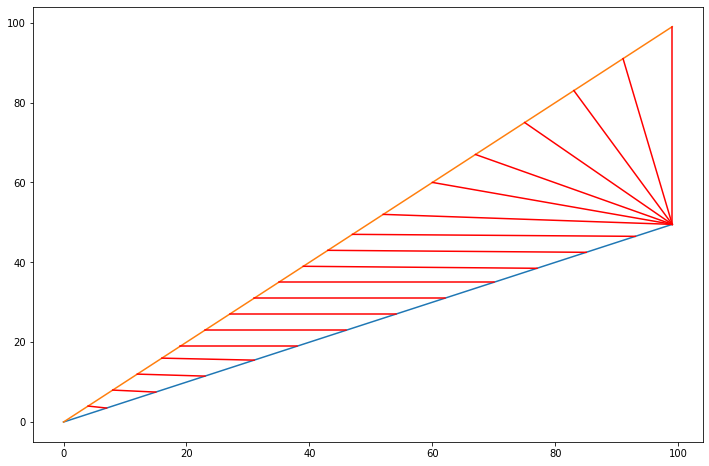

In [ ]:
s, t = np.arange(100)/2, np.arange(100)
matches = dynamic_time_warping(s,t)

plt.figure(figsize=(12,8))
plt.plot(s)
plt.plot(t)
for p1, p2 in matches[np.linspace(0, len(matches)-1, num=20, endpoint=True, dtype=int)]:
    plt.plot((p1, p2), (s[p1], t[p2]), 'r-')

### sin

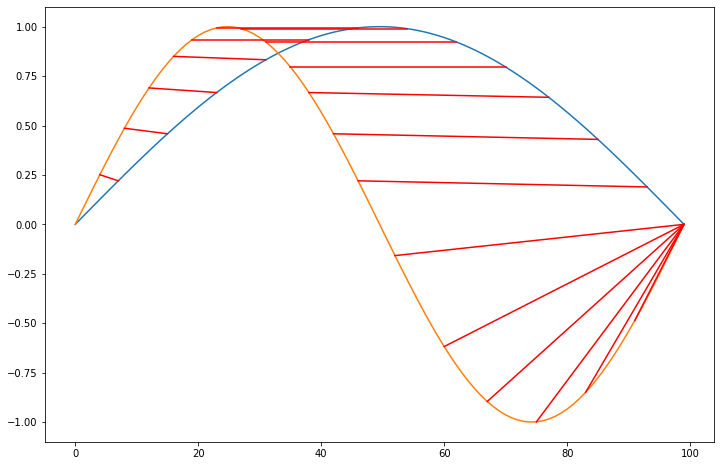

In [ ]:
s, t = np.sin(np.linspace(0, np.pi, num=100, endpoint=True)), np.sin(np.linspace(0, 2*np.pi, num=100, endpoint=True))
matches = dynamic_time_warping(s,t)

plt.figure(figsize=(12,8))
plt.plot(s)
plt.plot(t)
for p1, p2 in matches[np.linspace(0, len(matches)-1, num=20, endpoint=True, dtype=int)]:
    plt.plot((p1, p2), (s[p1], t[p2]), 'r-')

### tanh

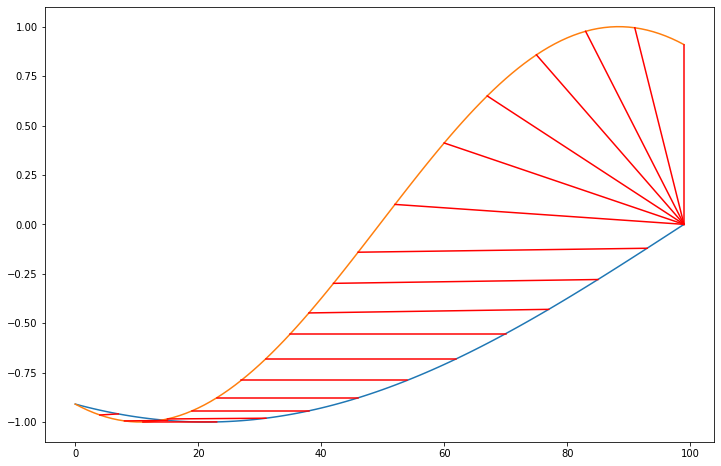

In [ ]:
s, t = np.sin(np.linspace(-2, 0, num=100, endpoint=True)), np.sin(np.linspace(-2, 2, num=100, endpoint=True))
matches = dynamic_time_warping(s,t)

plt.figure(figsize=(12,8))
plt.plot(s)
plt.plot(t)
for p1, p2 in matches[np.linspace(0, len(matches)-1, num=20, endpoint=True, dtype=int)]:
    plt.plot((p1, p2), (s[p1], t[p2]), 'r-')

## c)

In [ ]:
def generate_time_series(starting_point=0, len=1000, alpha=0.995):
    s = np.empty(len, dtype=float)
    s[0] = starting_point
    momentum = 0
    for pos in range(1, len):
        momentum = alpha*momentum + np.random.normal(0, 1)
        s[pos] = s[pos-1] + momentum
    s -= np.min(s)
    s /= np.max(s)
    return s

In [ ]:
def make_random_copy(s, base_len=1000, len=100):
    a = np.floor(np.random.uniform(0, base_len-len))
    b = np.floor(np.random.uniform(a+len, base_len))
    return s[np.linspace(a, b, num=len, endpoint=True, dtype=int)].copy()

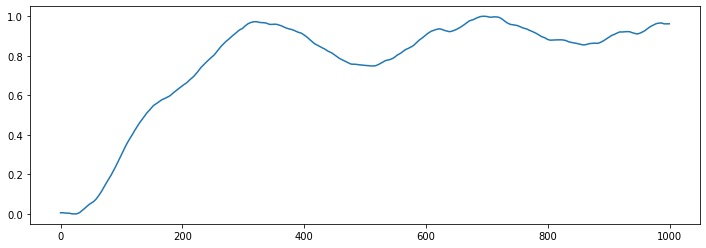

In [ ]:
plt.figure(figsize=(12,4))
base_time_series = generate_time_series()
plt.plot(base_time_series)

(0.0, 1.0)

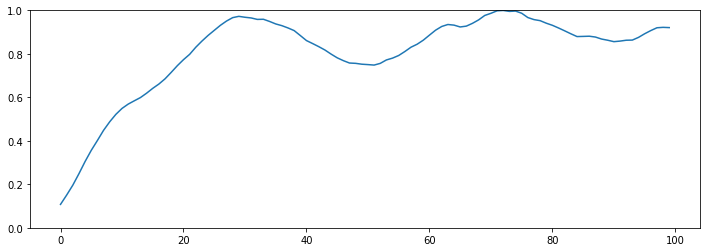

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(make_random_copy(base_time_series))
plt.ylim((0,1))

## d)

In [ ]:
time_series_count = 10
copies_count = 10
len_base = 1000
len_copy = 100
time_series = np.empty((time_series_count, copies_count, len_copy))
for ts_num in range(time_series_count):
    ts = generate_time_series(len=len_base)
    for cp_num in range(copies_count):
        time_series[ts_num, cp_num, :] = make_random_copy(ts, len=len_copy)

In [56]:
t0 = time()
distances = np.empty((time_series_count, copies_count, time_series_count, copies_count))
for ts1 in range(time_series_count):
    for cp1 in range(copies_count):
        for ts2 in range(time_series_count):
            for cp2 in range(copies_count):
                distances[ts1, cp1, ts2, cp2] = dynamic_time_warping(time_series[ts1, cp1], time_series[ts2, cp2], get_dist=True)

print(time() - t0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in add
  This is separate from the ipykernel package so we can avoid doing imports until


1250.3241128921509


21 min dla 10 kopii, dla 100 ~33h